In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
df= pd.read_csv("D:\Manjula\Staples Pricing ADS\Staples Bucketing\Staples_df_rol_item_with_affluence.csv")

In [3]:
rice_df = df[df["item_no"]==100096089]
rice_df_19 = rice_df[pd.to_datetime(rice_df["date"])<'2020-01-01']

In [4]:
dataset = rice_df_19.bill_qty.values #numpy.ndarray
dataset = dataset.astype('float32')

In [12]:
dataset = dataset.reshape(-1,1)

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
dataset = scaler.fit_transform(dataset)

In [20]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
print(dataset.shape)
print(train_size)
print(test_size)

(306, 1)
244
62


In [21]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [86]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [94]:
# reshape into X=t and Y=t+1
look_back = 40
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [95]:
print(X_train.shape)
print(X_test.shape)

(203, 40)
(21, 40)


In [96]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [97]:
X_train.shape

(203, 1, 40)

In [98]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/30
3/3 [==============================] - 0s 149ms/step - loss: 0.0527 - val_loss: 0.0126
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0341 - val_loss: 0.0063
Epoch 3/30
3/3 [==============================] - 0s 17ms/step - loss: 0.0253 - val_loss: 0.0055
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0239 - val_loss: 0.0073
Epoch 5/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0251 - val_loss: 0.0082
Epoch 6/30
3/3 [==============================] - 0s 104ms/step - loss: 0.0250 - val_loss: 0.0074
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0231 - val_loss: 0.0058
Epoch 8/30
3/3 [==============================] - 0s 17ms/step - loss: 0.0210 - val_loss: 0.0044
Epoch 9/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0196 - val_loss: 0.0037
Epoch 10/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0190 - val_loss: 0.0035
Epoch 11/30
3/3 [==========

In [99]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 75.24982839077713
Train Root Mean Squared Error: 111.90458973782344
Test Mean Absolute Error: 48.6091144994965
Test Root Mean Squared Error: 53.46021616026567


Predicting --> 21  data points


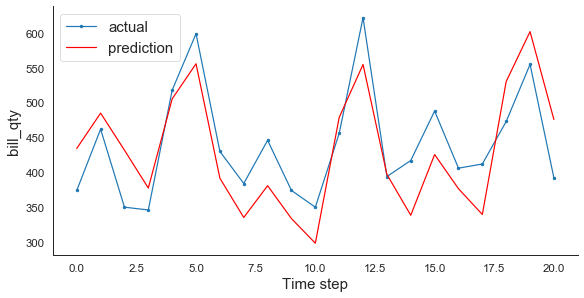

In [100]:
n = X_test.shape[0]
print("Predicting -->", n," data points")
aa=[x for x in range(n)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:n], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:n], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('bill_qty', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();